In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import KFold

## Загрузка датасета

In [20]:
# path = './csv/abalone.csv'
path = 'https://raw.githubusercontent.com/aiedu-courses/stepik_eda_and_dev_tools/main/datasets/abalone.csv'
df = pd.read_csv(path)

In [ ]:
df.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,NaN,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


## Общее исследование данных

Посмотрим размеры таблицы, число строк и столбцов

In [ ]:
df.shape

(4177, 9)

Количество пропусков в столбцах

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4078 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4078 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4127 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


In [ ]:
df.describe()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
count,4177.000000,4078.000000,4177.000000,4078.000000,4177.000000,4177.000000,4127.000000,4177.000000
mean,0.523992,0.407840,0.139516,0.827306,0.359367,0.180594,0.239072,9.933684
std,0.120093,0.099286,0.041827,0.490348,0.221963,0.109614,0.138942,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.440500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.798500,0.336000,0.171000,0.235000,9.000000
75%,0.615000,0.480000,0.165000,1.150875,0.502000,0.253000,0.328250,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


In [ ]:
df.isna().sum()

Sex                0
Length             0
Diameter          99
Height             0
Whole weight      99
Shucked weight     0
Viscera weight     0
Shell weight      50
Rings              0
dtype: int64

In [ ]:
# процент данных, который останется при удалении объектов с пропущенными значениями.
df.dropna().shape[0]/df.shape[0]

0.9420636820684702

Количество данных небольшое, что позволит в дальнейшем использовать модели различной сложности и позволит валидацию моделей с помощью KFold с большим количеством folds.

Пропуски есть, но их немного и находятся в столбцах Diameter, Whole weight, Shell weight

## Однофакторный анализ

### Выбросы, ошибочные значения

#### Сразу посмотрим на единственные категориальный признак - Sex

In [ ]:
df['Sex'].value_counts()

M    1447
I    1276
F    1259
f     195
Name: Sex, dtype: int64

Есть лишняя категория 'f', которая на самом деле является категорией 'F'.

После чего преобразуем признак Sex с помощью get_dummes с удалением столбца.

Изменим датасет: добавим новые признаки (выделенные get_dummes) и удалим исходный признак 'Sex'.

In [21]:
df['Sex'] = df['Sex'].apply(lambda x: 'F' if x == 'f' else x)
df = pd.concat([df, pd.get_dummies(df['Sex'], drop_first=True)], axis=1)
df.drop('Sex', axis=1, inplace=True)

#### Поищем выбросы с помощью boxplot

<Axes: >

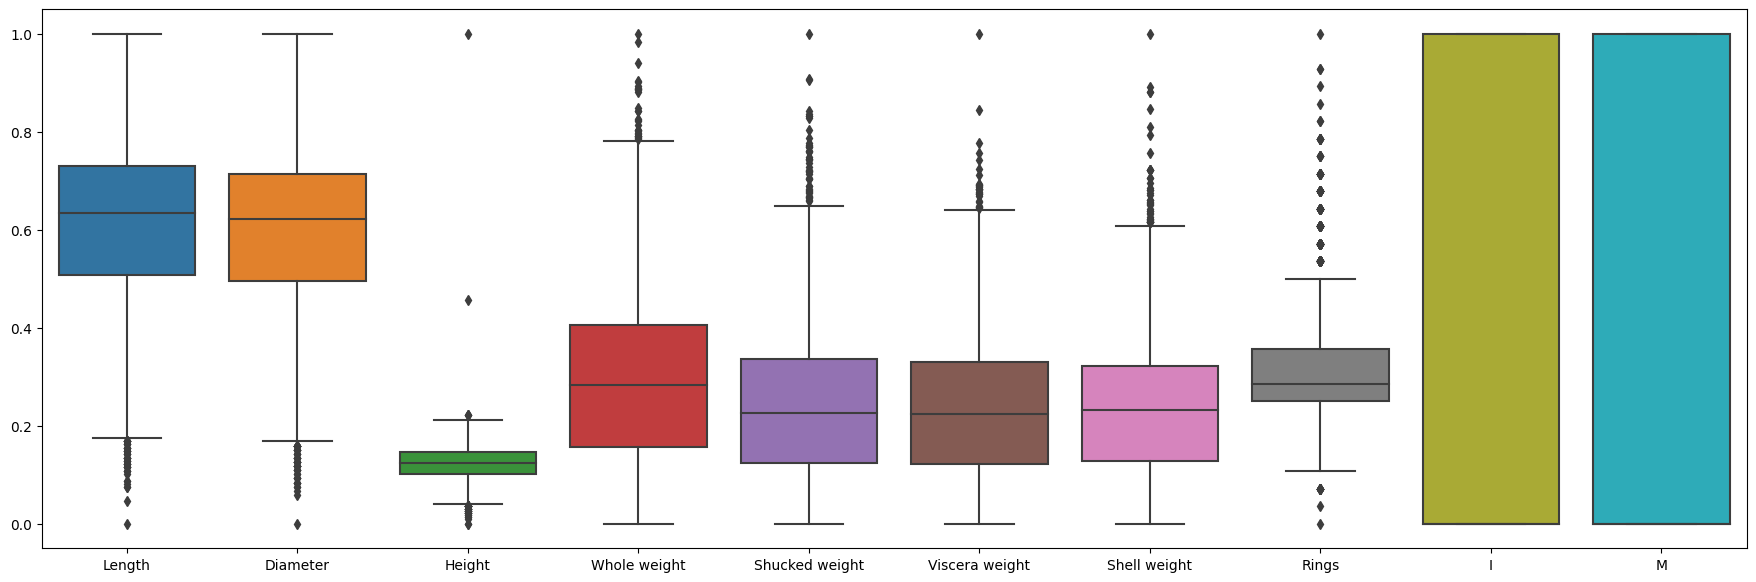

In [7]:
plt.figure(figsize=(22,7))
df_tmp = pd.DataFrame(MinMaxScaler().fit_transform(df.dropna()), columns=df.columns)
sns.boxplot(data=df_tmp)

Можно наблюдать, как некотрые значения параметров превышают 1,5 межквартильных размаха. Однако не всегда это означает выбросы, скорее редкие значения (как например для количества колец). Также подобные значения часто являются особенностями распределения признака (Несколько признаков распределены больше по пуассону).

Однако для некоторых признаков наблюдаются более выраженные и уникальные отклонения, которые можно считать выбросами (отклоняются более чем на 2,5-3 межквартильныз размаха). Такие данные есть в следующих признаках:

- heigth (1.130, 0.515, далее все значения 0,250 и ниже сгруппированы рядом)
- Shell weight (1.35, 1.00, далее все значения 0.897 и ниже сгруппированы рядом)

Помимо прочего видны нулевые значения, которые нулевыми быть не могут:

- Length
- Diameter
- Heigth

Логично будет удалить объекты с нулевыми значениями данных признаков из датасета

In [ ]:
df.sort_values(by='Height', ascending=False).head(7)

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,I,M
2051,0.455,0.355,1.130,0.5940,0.3320,0.1160,0.1335,8,0,0
1417,0.705,0.565,0.515,2.2100,1.1075,0.4865,0.5120,10,0,1
1763,0.775,0.630,0.250,2.7795,1.3485,0.7600,0.5780,12,0,1
1428,0.815,0.650,0.250,2.2550,0.8905,0.4200,0.7975,14,0,0
2179,0.595,0.470,0.250,1.2830,0.4620,0.2475,0.4450,14,0,0
307,0.645,0.515,0.240,1.5415,0.4710,0.3690,0.5350,13,0,1
1528,0.725,0.575,0.240,2.2100,1.3510,0.4130,0.5015,13,0,1


In [ ]:
df.sort_values(by='Shell weight', ascending=False).head(7)

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,I,M
163,0.725,0.560,0.210,2.1410,0.6500,0.3980,1.0050,18,0,0
891,0.730,0.595,0.230,2.8255,1.1465,0.4190,0.8970,17,0,0
2161,0.715,0.565,0.240,2.1995,0.7245,0.4650,0.8850,17,0,0
2108,0.665,0.535,0.225,2.1835,0.7535,0.3910,0.8850,27,0,1
166,0.725,0.575,0.175,2.1240,0.7650,0.4515,0.8500,20,0,0
164,0.650,0.545,0.230,1.7520,0.5605,0.2895,0.8150,16,0,0
1428,0.815,0.650,0.250,2.2550,0.8905,0.4200,0.7975,14,0,0


In [22]:
# отдельно добавил df['Shell weight'].isna(), чтобы не удалялись пропущенные значения
# после они обрабатываться будут
df = df[(df['Height'] <= 0.25) & ((df['Shell weight'] <= 0.9) | (df['Shell weight'].isna())) &
             (df['Length'] != 0) & (df['Diameter'] != 0) & (df['Height'] != 0)]

## Обработка пропущенных значений

### Посмотрим на нулевые значения

In [ ]:
df.isna().sum()

Length             0
Diameter          99
Height             0
Whole weight      99
Shucked weight     0
Viscera weight     0
Shell weight      50
Rings              0
I                  0
M                  0
dtype: int64

Пропуски есть в столбцах Diameter, Whole weight и Shell weight

Посмотрим, не связаны ли эти пропуски:

In [23]:
na_cols = ['Diameter', 'Shell weight', 'Whole weight']

In [ ]:
# для каждого из столбцов с пропуском выделяем строки с Nan и смотрим, где еще есть Nan
nan_analyse = pd.concat([df[df[col_x].isna()].isna().sum() for col_x in na_cols], axis=1)
nan_analyse.columns = na_cols
nan_analyse

,Diameter,Shell weight,Whole weight
Length,0,0,0
Diameter,99,1,4
Height,0,0,0
Whole weight,4,1,99
Shucked weight,0,0,0
Viscera weight,0,0,0
Shell weight,1,50,1
Rings,0,0,0
I,0,0,0
M,0,0,0


Видим, что пропуски не связаны и пересекаются случайно.

Посмотрим на корреляцю между признаками:

In [ ]:
df.corr().style.background_gradient()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,I,M
Length,1.000000,0.986675,0.900798,0.925317,0.898090,0.902966,0.899424,0.556172,-0.533823,0.218269
Diameter,0.986675,1.000000,0.907059,0.925983,0.893386,0.899706,0.906742,0.571993,-0.546957,0.223870
Height,0.900798,0.907059,1.000000,0.889541,0.837419,0.866642,0.892118,0.609707,-0.538187,0.215595
Whole weight,0.925317,0.925983,0.889541,1.000000,0.969684,0.966644,0.956392,0.538988,-0.537825,0.229297
Shucked weight,0.898090,0.893386,0.837419,0.969684,1.000000,0.931840,0.884153,0.420772,-0.504610,0.230592
Viscera weight,0.902966,0.899706,0.866642,0.966644,0.931840,1.000000,0.908728,0.503402,-0.537368,0.222529
Shell weight,0.899424,0.906742,0.892118,0.956392,0.884153,0.908728,1.000000,0.625742,-0.529640,0.215386
Rings,0.556172,0.571993,0.609707,0.538988,0.420772,0.503402,0.625742,1.000000,-0.423851,0.168496
I,-0.533823,-0.546957,-0.538187,-0.537825,-0.504610,-0.537368,-0.529640,-0.423851,1.000000,-0.482899
M,0.218269,0.223870,0.215595,0.229297,0.230592,0.222529,0.215386,0.168496,-0.482899,1.000000


Видим, что корреляция между признаками очень сильная и положительная. Потенциально это приводит к проблеме обучения моделей и трудности интерпретации. Наверное имеет смысл провести факторный анализ.

Количество пропусков только 6%, а значит их удаление не должно критично повлиять на будущую модель.

Однако, благодаря высокой корреляции можно довольно просто предсказать пропущенные значения с помощью линейной модели.

In [24]:
def predict_nans_r2_KFold(df_x, col_x, del_cols=na_cols):

    pipe = make_pipeline(MinMaxScaler(), LinearRegression())

    train = df_to_train = df_x.dropna()
    X = train.drop(del_cols, axis=1)
    y = train[[col_x]]

    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # вместо этого добавил KFold валидацию и беру среднее от всех прогонов

    # перешел на KFold потому что без него при удалении одного признака (целевого) из выборки
    # качество предсказания для Whole weight падало, что было совершенно нелогичным.

    metrics_all = []
    kf = KFold(n_splits=7, shuffle=True, random_state=42)

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        pipe.fit(X_train, y_train)
        pred = pipe.predict(X_test)

        metric = r2_score(y_test, pred)
        metrics_all.append(metric)

    print(f"r2 для признака {col_x} - {np.mean(metrics_all)}")

In [25]:
print(f"Если предсказывать по всем столбцам кроме {', '.join(na_cols)}:")
for col_x in na_cols:
    predict_nans_r2_KFold(df, col_x)

print("\n А если предсказывать, удаляя только целевой признак:")
for col_x in na_cols:
    predict_nans_r2_KFold(df, col_x, del_cols=[col_x])


Если предсказывать по всем столбцам кроме Diameter, Shell weight, Whole weight:
r2 для признака Diameter - 0.9759781079455182
r2 для признака Shell weight - 0.8966188508339076
r2 для признака Whole weight - 0.9794978938921138

 А если предсказывать, удаляя только целевой признак:
r2 для признака Diameter - 0.9764625573310992
r2 для признака Shell weight - 0.9545614523291931
r2 для признака Whole weight - 0.9910435297659088


Метрика r2 хорошая для предсказания Diameter и Whole weight.

Однако на Shell weigth она проседает. (на whole наоборот кажется по случайности. Нужна KFold, чтобы нормально было)

1. Поэтому будем сперва предсказывать Diameter используя как train все, кроме этих трех столбцов с пропусками.

2. Затем предсказывать Whole weigth по тому же train, но с добавлением предсказанного Diameter

3. Затем уже по всем данным предсказывать Shell, которая по всем признакам предсказывается значительно лучше.

In [26]:
def get_predict_maker(df_x, col_x, del_cols=na_cols):
    """Принимает df, столбец для предсказания и те столбцы,
    которые не должны учитываться моделью (потому что в них есть Nan)"""
    pipe = make_pipeline(MinMaxScaler(), LinearRegression())

    train = df_x.dropna()

    train_X = train.drop(del_cols, axis=1)
    train_y = train[[col_x]]

    pipe.fit(train_X, train_y)

    return pipe

def pass_nan_with_maker(x, maker, col_x, del_cols=na_cols):
    """Принимает значения объекта, модель для предсказания объекта, если он Nan
    столбец для предсказания и столбцы, которые не должны учитываться для предсказания"""
    if x.isna()[col_x]:
        x_df = pd.DataFrame(x)
        train = x_df.drop(del_cols).transpose()

        diameter_new = maker.predict(train)
        x[col_x] = diameter_new[0][0]
        #result = x.fillna(diameter_new[0][0]) НЕЛЬЗЯ потому что заменяет все Nand
        return x
    else:
        return x

In [28]:
# сперва обучаем линейную модель предсказывать Diameter и предскажем его
make_diameter = get_predict_maker(df, 'Diameter')
df = df.apply(pass_nan_with_maker, maker=make_diameter, col_x='Diameter', axis=1)

df.isna().sum()

Length             0
Diameter           0
Height             0
Whole weight      99
Shucked weight     0
Viscera weight     0
Shell weight      50
Rings              0
I                  0
M                  0
dtype: int64

In [30]:
# затем на основе в том числе предсказанных Diameter предскажем Whole weight
make_Whole = get_predict_maker(df, 'Whole weight',
                               del_cols = ['Whole weight', 'Shell weight'])
df = df.apply(pass_nan_with_maker, maker=make_Whole, col_x='Whole weight',
              del_cols = ['Whole weight', 'Shell weight'], axis=1)

df.isna().sum()

Length             0
Diameter           0
Height             0
Whole weight       0
Shucked weight     0
Viscera weight     0
Shell weight      50
Rings              0
I                  0
M                  0
dtype: int64

In [31]:
# затем обучаем линейную модель на предсказывание shell weigth
make_Shell = get_predict_maker(df, 'Shell weight', del_cols=['Shell weight'])
# заполняем пропуски для shell weigth
df = df.apply(pass_nan_with_maker, maker=make_Shell, col_x='Shell weight', del_cols='Shell weight', axis=1)
df.isna().sum()

Length            0
Diameter          0
Height            0
Whole weight      0
Shucked weight    0
Viscera weight    0
Shell weight      0
Rings             0
I                 0
M                 0
dtype: int64

In [32]:
df.describe()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,I,M
count,4172.000000,4172.000000,4172.000000,4172.000000,4172.000000,4172.000000,4172.000000,4172.000000,4172.000000,4172.000000
mean,0.523990,0.407899,0.139239,0.828571,0.359234,0.180543,0.238564,9.933605,0.305369,0.346596
std,0.120035,0.099227,0.038366,0.489615,0.221686,0.109486,0.138686,3.222829,0.460619,0.475943
min,0.075000,0.055000,0.010000,0.002000,0.001000,0.000500,-0.012275,1.000000,0.000000,0.000000
25%,0.450000,0.350000,0.115000,0.441875,0.186000,0.093500,0.130000,8.000000,0.000000,0.000000
50%,0.545000,0.425000,0.140000,0.800000,0.336000,0.171000,0.234000,9.000000,0.000000,0.000000
75%,0.615000,0.480000,0.165000,1.153000,0.501625,0.252625,0.327625,11.000000,1.000000,1.000000
max,0.815000,0.650000,0.250000,2.825500,1.488000,0.760000,0.897000,29.000000,1.000000,1.000000


Среди предсказанных значений появились некорректные - минимум признака shell weight < 0. Некорректное значение.

Изменим их значение на 0.

In [33]:
df[df < 0] = 0

### Посмотрим на распределение преобразованных признаков

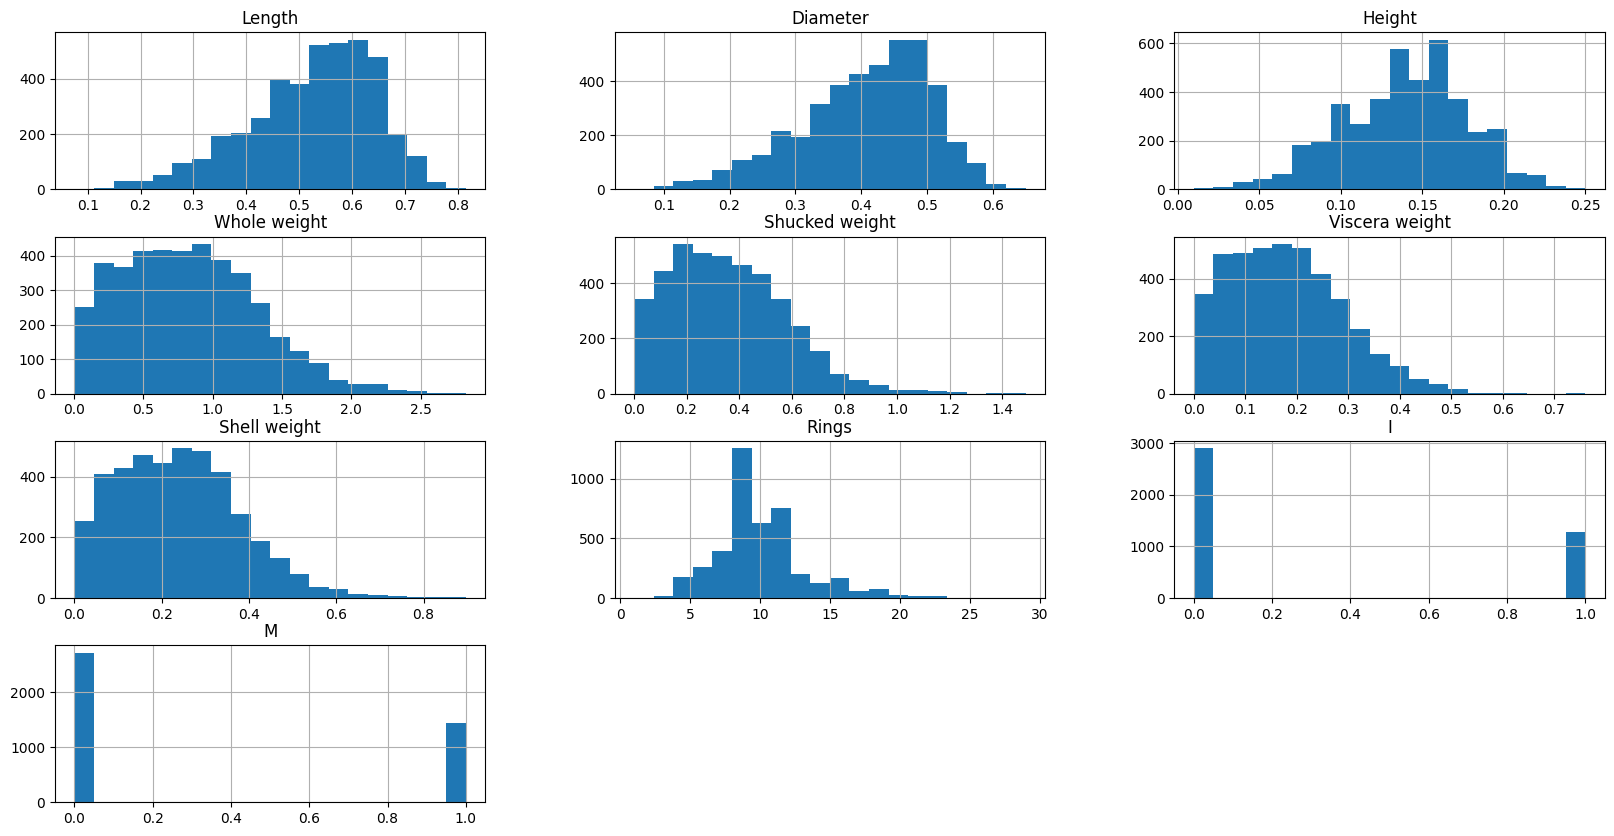

In [34]:
df.hist(layout=(-1,3), figsize=(20,10), bins=20);

Видим, что некоторые признаки распределены будто ближе к Пуассоновскому распределению.

Лучше преобразовать признаки так, чтобы их распределение приблизилось к нормальному.

Попробуем преобразования:

- взятие корня разных степеней
- логарифмирование признака по разным степеням

Для оценки качества преобразований будем использовать критерии

Известно, что модели лучше работают с признаками, распределенными по нормальному закону. Посмотрим, насколько эти признаки близки к нормальному распределению.

Для этого будем использовать

- тест Калмогорова-Смирнова
- тест Шапиро-Вилка

Будем извлекать статистики и p-значения.

In [38]:
from scipy.stats import kstest
from scipy.stats import shapiro

def get_statistic_p_value(x):
    shap_stat, shap_p = shapiro(x)
    k_test_stat, k_test_p = kstest(x, 'norm')

    all_statistics = [shap_p, k_test_p, shap_stat, k_test_stat]

    result = [round(krit_x, 6) for krit_x in all_statistics]
    result = pd.Series(result)

    return result

In [39]:
# смотрим на p_values критериев на нормальность
p_values_cols = ['shap_p', 'k_test_p', 'shap_stat', 'k_test_sta']
p_values = df.apply(get_statistic_p_value)
p_values.index = p_values_cols
p_values

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,I,M
shap_p,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
k_test_p,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
shap_stat,0.969488,0.970609,0.993076,0.972707,0.962319,0.968306,0.971780,0.931268,0.579055,0.601466
k_test_sta,0.575260,0.550692,0.510680,0.506234,0.501316,0.500318,0.500717,0.998171,0.500000,0.500000


In [43]:
df_tmp = df.copy()

df_tmp['Diameter'] = df_tmp['Diameter'].apply(lambda x: pow(x,0.5))
df_tmp['Length'] = df_tmp['Length'].apply(lambda x: pow(x,0.5))

for col_x in ['Whole weight', 'Shucked weight',  'Viscera weight', 'Shell weight']:
    df_tmp[f"{col_x}"] = df_tmp[col_x].apply(lambda x: pow(x, 0.71))
df_tmp = pd.DataFrame(StandardScaler().fit_transform(df_tmp), columns=df_tmp.columns)

# смотрим на статистики критериев на нормальность
statistic = df_tmp.apply(get_statistic_p_value)
statistic_cols =  ['shap_p', 'k_test_p', 'shap_stat', 'k_test_sta']
statistic.index = statistic_cols
statistic

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,I,M
shap_p,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
k_test_p,0.000000,0.000000,0.000000,0.004377,0.003479,0.000610,0.001833,0.000000,0.000000,0.000000
shap_stat,0.937626,0.938486,0.993076,0.991765,0.990526,0.990955,0.992868,0.931268,0.579055,0.601466
k_test_sta,0.092355,0.094012,0.062759,0.027051,0.027554,0.031107,0.028912,0.145184,0.440976,0.420194


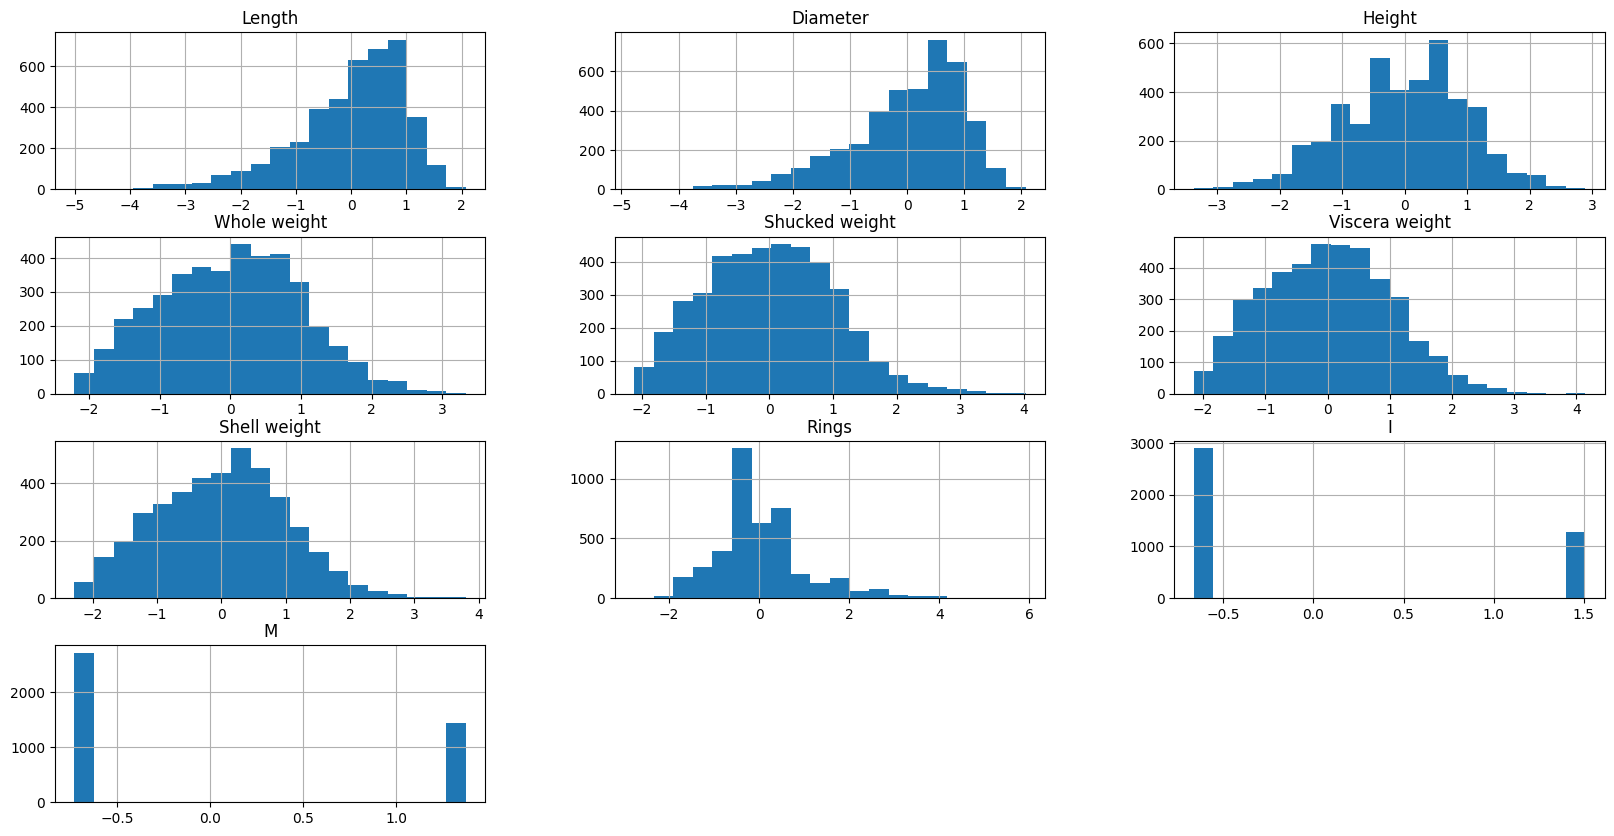

In [44]:
df_tmp.hist(layout=(-1,3), figsize=(20,10), bins=20);

Видим, что p-value увеличивается, как и статистики критериев. Следовательно, данное преобразование приводит признаки к более нормальному виду.

Однако для EDA это пожалуй черезчур. Я приостановился, перед построением модели для выбивания лучшей метрики можно такие подходы использовать для каждого из признаков, подбирая наилучшее значение степени. Сейчас, в рамках EDA оставим признаки без преобразования несмотря на то, что они распределены не по нормальному закону.

## Анализ распределения целевой переменной

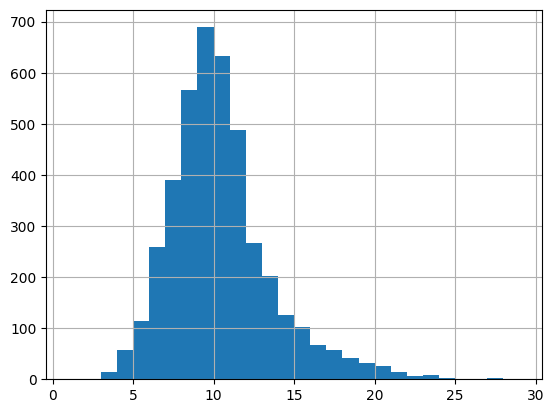

In [45]:
unique_count = len(df['Rings'].unique())
df['Rings'].hist(bins=unique_count);

Распределение являестся близким к нормальному с небольшой ассиметрией в сорону маньших значений.

Из-за увеличенного хвоста распределения в области больших значений, модель не сможет качественно предсказывать большие значения целевой переменной.

Наилучшие предсказания модели будут для диапазона Rings [5:15]

### Корреляция Пирсона между признаками

In [46]:
df.corr().style.background_gradient()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,I,M
Length,1.000000,0.986962,0.900798,0.925494,0.898090,0.902966,0.899937,0.556172,-0.533823,0.218269
Diameter,0.986962,1.000000,0.907521,0.926065,0.893707,0.900022,0.907902,0.573718,-0.546303,0.223572
Height,0.900798,0.907521,1.000000,0.888925,0.837419,0.866642,0.893008,0.609707,-0.538187,0.215595
Whole weight,0.925494,0.926065,0.888925,1.000000,0.969875,0.966754,0.956018,0.539532,-0.539223,0.230657
Shucked weight,0.898090,0.893707,0.837419,0.969875,1.000000,0.931840,0.885131,0.420772,-0.504610,0.230592
Viscera weight,0.902966,0.900022,0.866642,0.966754,0.931840,1.000000,0.909274,0.503402,-0.537368,0.222529
Shell weight,0.899937,0.907902,0.893008,0.956018,0.885131,0.909274,1.000000,0.627817,-0.530843,0.217378
Rings,0.556172,0.573718,0.609707,0.539532,0.420772,0.503402,0.627817,1.000000,-0.423851,0.168496
I,-0.533823,-0.546303,-0.538187,-0.539223,-0.504610,-0.537368,-0.530843,-0.423851,1.000000,-0.482899
M,0.218269,0.223572,0.215595,0.230657,0.230592,0.222529,0.217378,0.168496,-0.482899,1.000000


Видим по всем признакам значительную положительную корреляцию

Самая большая линейная связь наблюдается по 2м признакам: Height и Shell weight

### Посмотрим распределение целевого признака по Height и Shell weight.

In [47]:
# создадим временный датасет, в котором вернем категориальный признак Sex
# вернем для использования его как разделителя в hue графиков
# и для корреляции с помощью ANOVA (по заданию ж нужно, + потренируюсь)
df_tmp  = pd.read_csv(path)
df_tmp['Sex'] = df_tmp['Sex'].apply(lambda x: 'F' if x == 'f' else x)
df_tmp = pd.concat([df, df_tmp['Sex']], axis=1).dropna()

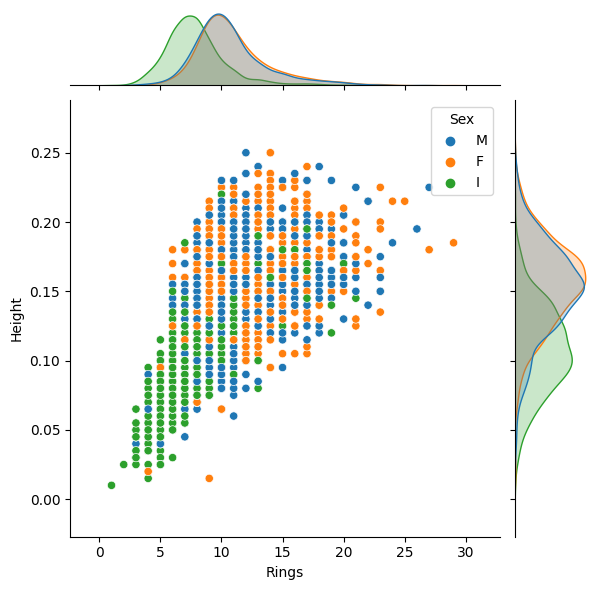

In [48]:
sns.jointplot(data=df_tmp, x='Rings', y='Height', hue='Sex');


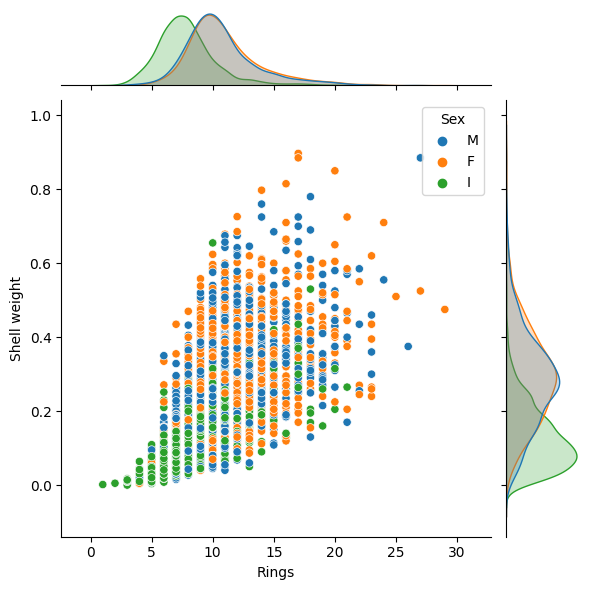

In [49]:
sns.jointplot(data=df_tmp, x='Rings', y='Shell weight', hue='Sex');

Видим хорошую положительную корреляцию. Линейная связь между высотой и таргетом, подобие квадратичной у shell weigth и таргетом

При увеличении значений признаков, значение целевого признака становится менее конкретным (хвост наверху справа расплывается).

Также видим, что младенцы (Sex = I) имею меньший Rings. Учитывая, что целевая переменная линейно связана с возрастом, логично, что младенцы являются объектами с самым маленьким возрастом.

В общем и целом взаимосвязи признаков с target - логично. Чем больше возраст, тем больше значения параметров веса и различных размеров.

### ANOVA между признаками Sex и целевым признаком.

In [50]:
df_tmp  = pd.read_csv(path)
df_tmp['Sex'] = df_tmp['Sex'].apply(lambda x: 'F' if x == 'f' else x)

In [51]:
from scipy.stats import f_oneway

In [52]:
tmp = df_tmp.groupby('Sex')['Rings'].apply(list)
Anova_res = f_oneway(*tmp)
Anova_res

F_onewayResult(statistic=463.0629242002653, pvalue=2.35303895865748e-182)

Очевидный результат - связь целевой переменной с полом есть, так как в признаке Sex есть категория Младенец (I)

Посмотрим на анализ anova только при наличии 2х категорий: male и female

In [53]:
df_tmp = df_tmp[df_tmp['Sex'] != 'I']
df_tmp['Sex'].value_counts()

F    1454
M    1447
Name: Sex, dtype: int64

In [54]:
tmp = df_tmp.groupby('Sex')['Rings'].apply(list)
Anova_res = f_oneway(*tmp)
Anova_res

F_onewayResult(statistic=7.949301334305366, pvalue=0.00484326288311071)

Видим значительное изменение p-значения (примерно на 180 порядков).

Несмотря на это, p-value все равно принимает маленькие значения (меньше даже 1% уровня), поэтому стоит сказать, что признаки Sex и Rings взаимосвязаны.

In [60]:
# сохраним данные, чтобы далее сравнивать pandas и polars
df_big = df.copy()
n_repeat = round(1000000/df.shape[0])


for i in range(n_repeat):
  df_big = pd.concat([df_big, df])

df_big.to_csv("abalone_big.csv", index=False)
df_big.shape[0]

1005452

## Увеличение размера датасета и сравнение Pandas и Polars

In [55]:
# !pip install ./whl/polars-0.18.7-cp38-abi3-win_amd64.whl
!pip install polars

In [56]:
import polars as pl

### Загрузка данных

In [70]:
%%time
df = pd.read_csv('abalone_big.csv')

CPU times: user 860 ms, sys: 74.3 ms, total: 934 ms
Wall time: 937 ms


In [72]:
%%time
df_pl = pl.read_csv('abalone_big.csv')

CPU times: user 821 ms, sys: 99 ms, total: 920 ms
Wall time: 505 ms


Загрузка данных с помощью pandas медленнее, чем в Polars примерно в 2 раза. (1000 ms Pandas против 500 ms Polars)
У обеих библиотек заметно уменьшение времени работы при повторном запуске ячейки

### Фильтрация данных

In [112]:
# Pandas
%%time
df.query('Rings > 5')

CPU times: user 38 ms, sys: 38.1 ms, total: 76.1 ms
Wall time: 76.3 ms


,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,I,M
0,0.455,0.365,0.095,0.514000,0.2245,0.1010,0.1500,15.0,0.0,1.0
1,0.350,0.265,0.090,0.225500,0.0995,0.0485,0.0700,7.0,0.0,1.0
2,0.530,0.420,0.135,0.677000,0.2565,0.1415,0.2100,9.0,0.0,0.0
3,0.440,0.365,0.125,0.543789,0.2155,0.1140,0.1550,10.0,0.0,1.0
4,0.330,0.255,0.080,0.205000,0.0895,0.0395,0.0550,7.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
1005447,0.565,0.450,0.165,0.887000,0.3700,0.2390,0.2490,11.0,0.0,0.0
1005448,0.590,0.440,0.135,0.966000,0.4390,0.2145,0.2605,10.0,0.0,1.0
1005449,0.600,0.475,0.205,1.176000,0.5255,0.2875,0.3080,9.0,0.0,1.0
1005450,0.625,0.485,0.150,1.094500,0.5310,0.2610,0.2960,10.0,0.0,0.0


In [108]:
# Polars
%%time
df_pl.filter(pl.col('Rings') > 5)

CPU times: user 23.4 ms, sys: 147 ms, total: 170 ms
Wall time: 94.5 ms


Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,I,M
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.455,0.365,0.095,0.514,0.2245,0.101,0.15,15.0,0.0,1.0
0.35,0.265,0.09,0.2255,0.0995,0.0485,0.07,7.0,0.0,1.0
0.53,0.42,0.135,0.677,0.2565,0.1415,0.21,9.0,0.0,0.0
0.44,0.365,0.125,0.543789,0.2155,0.114,0.155,10.0,0.0,1.0
0.33,0.255,0.08,0.205,0.0895,0.0395,0.055,7.0,1.0,0.0
0.425,0.3,0.095,0.3515,0.141,0.0775,0.12,8.0,1.0,0.0
0.53,0.415,0.15,0.7775,0.237,0.1415,0.33,20.0,0.0,0.0
0.545,0.425,0.125,0.768,0.294,0.1495,0.26,16.0,0.0,0.0
0.475,0.37,0.125,0.5095,0.2165,0.1125,0.165,9.0,0.0,1.0


В фильтрации данных Pandas в среднем немного лучше, чем Polars. Однако разница не существенная. (75 ms Pandas против 90 ms Polars)


### Агрегирование данных

In [136]:
#Pandas
%%time
df.groupby('Rings').agg({'Diameter':'mean','Height' : 'max'})

CPU times: user 36.7 ms, sys: 0 ns, total: 36.7 ms
Wall time: 37.7 ms


,Diameter,Height
Rings,,
1.0,0.055000,0.010
2.0,0.100000,0.025
3.0,0.128449,0.065
4.0,0.161716,0.095
5.0,0.211112,0.115
6.0,0.279037,0.180
7.0,0.321488,0.185
8.0,0.384889,0.200
9.0,0.425314,0.215


In [135]:
# Polars
%%time
df_pl.groupby('Rings').agg([pl.mean('Diameter'), pl.median('Height')])

CPU times: user 43 ms, sys: 447 µs, total: 43.5 ms
Wall time: 58.2 ms


Rings,Diameter,Height
f64,f64,f64
11.0,0.470676,0.165
20.0,0.482308,0.17
12.0,0.46248,0.16
21.0,0.485357,0.1725
5.0,0.211112,0.07
13.0,0.456431,0.16
18.0,0.468602,0.175
23.0,0.463164,0.165
6.0,0.279037,0.09


Разница во времени выполнении агрегирования между библиотеками Pandas и Polars практически нет. (примерно 30 - 35 ms для Pandas и для Polars)

### Итог сравнения Pandas и Polars

При фильтрации и агрегировании значительной разницы во времени выполнения замечено не было.

Небольшая и уверенная разница была только при загрузке данных (Polars на 20% выстрее, чем Polars)

Интерфейс взаимодействия с polars показался немного сложнее, чем pandas (что логично, pandas существует и поддерживается значительно дольше, чем polars).